### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

$$ \frac{\sigma L(a(x_i), y_i)}{\sigma a(x_i)} = 2(a(x_i) - y_i) \Longrightarrow r = 2 * (y - a(x)) $$
$$ \frac{\sigma e^{-a(x_i)y_i}}{\sigma a(x_i)} = -y_ie^{-a(x_i)y_i} \Longrightarrow r_i = y_ie^{-a(x_i)y_i} $$
$$ \frac{\sigma \log{(1+e^{-a(x_i)y_i})}}{\sigma a(x_i)} = \frac{-y_ie^{-a(x_i)y_i}}{1+e^{-a(x_i)y_i}} = \frac{-y_i}{1 + e^{a(x_i)y_i}} \Longrightarrow r_i = \frac{y_i}{1 + e^{y_ia(x_i)}} $$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [248]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm

In [266]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.01, n_estimators=1000, colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.trees = []
        self.f_idx = []
        self.args = args
        self.kwargs = kwargs
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        if init_model is None:
            f = np.zeros([X.shape[0]])
        else:
            init_model.fit(X, y)
            f = init_model.predict(X).astype('float64')
            self.trees.append(init_model)
            self.f_idx.append(np.arange(X.shape[1]))
        for _ in tqdm(range(self.n_estimators)):
            base_clf = base_model(*self.args, **self.kwargs)
            obj_idx = np.random.choice(X.shape[0], int(self.subsample * X.shape[0]))
            feat_idx = np.random.choice(X.shape[1], int(self.colsample * X.shape[1]))
            X_new = X[np.ix_(obj_idx, feat_idx)]

            if self.loss == 'mse':
                r = 2 * (y[obj_idx] - f[obj_idx])
            elif self.loss == 'exp':
                r = y[obj_idx] * np.exp(-f[obj_idx] * y[obj_idx])
            elif self.loss == 'log':
                r = y[obj_idx] / (1 + np.exp(f[obj_idx] * y[obj_idx]))  

            base_clf.fit(X_new, r)
            f += self.learning_rate * base_clf.predict(X[:, feat_idx])
            self.trees.append(base_clf)
            self.f_idx.append(feat_idx)

    def predict(self, X):
        pred = np.zeros([X.shape[0]])
        for i in range(self.n_estimators):
            pred += self.learning_rate * self.trees[i].predict(X[:, self.f_idx[i]])
        if (self.loss == "mse"):
            return np.around(pred).astype(int)
        elif (self.loss == "log" or self.loss == "exp"):
            return (pred > 0.5).astype('int')

In [263]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [187]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [188]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

100%|██████████| 1000/1000 [00:01<00:00, 846.42it/s]


1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [251]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [252]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [201]:
n_est = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
accur = []
for i in n_est:
    my_clf = MyGradientBoostingClassifier(n_estimators=i)
    my_clf.fit(X_train, y_train)
    accur.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

100%|██████████| 200/200 [00:32<00:00,  6.16it/s]


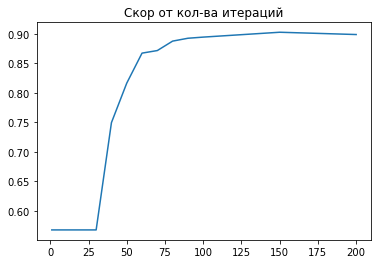

In [203]:
plt.plot(n_est, accur)
plt.title("Скор от кол-ва итераций")
plt.show()

Начиная с 50 +- одно и тоже. Чем больше, конечно, лучше, но с 50 будет быстрее

In [208]:
cs = np.linspace(0.2, 1, 8)
accur = []
for i in cs:
    my_clf = MyGradientBoostingClassifier(colsample=i, n_estimators=50)
    my_clf.fit(X_train, y_train)
    accur.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


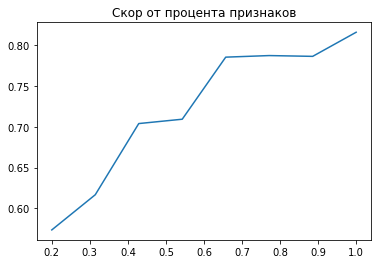

In [209]:
plt.plot(cs, accur)
plt.title("Скор от процента признаков")
plt.show()

Лучше когда все признаки

In [211]:
ss = np.linspace(0.2, 1, 8)
accur = []
for i in cs:
    my_clf = MyGradientBoostingClassifier(subsample=i, n_estimators=50)
    my_clf.fit(X_train, y_train)
    accur.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

100%|██████████| 50/50 [00:07<00:00,  6.85it/s]


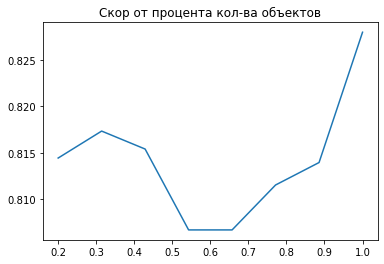

In [212]:
plt.plot(ss, accur)
plt.title("Скор от процента кол-ва объектов")
plt.show()

Лучше, когда все объекты

In [213]:
lr = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
accur = []
for i in lr:
    my_clf = MyGradientBoostingClassifier(learning_rate=i, n_estimators=50)
    my_clf.fit(X_train, y_train)
    accur.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


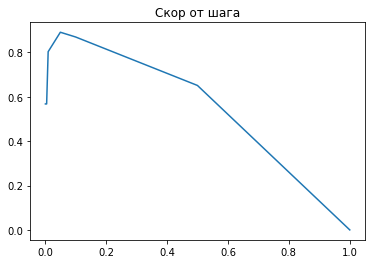

In [215]:
plt.plot(lr, accur)
plt.title("Скор от шага")
plt.show()

In [221]:
depth = [1, 2, 3, 5, 7, 11, 15]
accur = []
for i in depth:
    my_clf = MyGradientBoostingClassifier(learning_rate=0.05, n_estimators=50, max_depth=i)
    my_clf.fit(X_train, y_train)
    accur.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


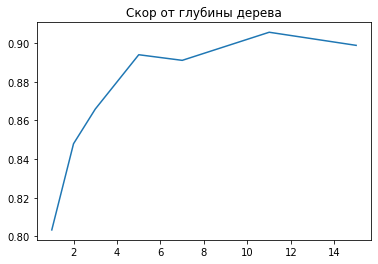

In [222]:
plt.plot(depth, accur)
plt.title("Скор от глубины дерева")
plt.show()

Наилучшая глубина - 11

In [223]:
my_clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.05, n_estimators=50, max_depth=11)
my_clf.fit(X_train, y_train)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


0.9079457364341085

In [224]:
my_clf = MyGradientBoostingClassifier(loss='log', learning_rate=0.05, n_estimators=50, max_depth=11)
my_clf.fit(X_train, y_train)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

100%|██████████| 50/50 [00:04<00:00, 10.74it/s]


0.8948643410852714

In [225]:
my_clf = MyGradientBoostingClassifier(loss='exp', learning_rate=0.05, n_estimators=50, max_depth=11)
my_clf.fit(X_train, y_train)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

100%|██████████| 50/50 [00:04<00:00, 10.68it/s]


0.8633720930232558

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [227]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.05, n_estimators=50, max_depth=11)
clf.fit(X_train, y_train, base_model=RandomForestRegressor)
accuracy_score(clf.predict(X_test), y_test)

100%|██████████| 50/50 [05:19<00:00,  6.40s/it]


0.9060077519379846

In [242]:
predicts = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.05, n_estimators=50, max_depth=11)
    clf.fit(X_train, y_train)
    predicts.append(accuracy_score(clf.predict(X_test), y_test))

100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


AttributeError: 'list' object has no attribute 'mean'

In [245]:
sum(predicts) / len(predicts)

0.8938759689922471

Скор остался таким же. Мне кажется, это из-за того, что нет разницы какая модель базовая, так как мы каждой новой моделью фиксим предыдущую, а за большое количество итераций с этим справится и слабая модель. Тем более 15 минут это больно. Потраченого времени жаль)))

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [264]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.05, n_estimators=50, max_depth=11)
clf.fit(X_train, y_train)
accuracy_score(clf.predict(X_test), y_test)

100%|██████████| 50/50 [00:05<00:00,  9.97it/s]


0.9001937984496124

In [265]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.05, n_estimators=50, max_depth=11)
clf.fit(X_train, y_train, init_model=LinearRegression())
accuracy_score(clf.predict(X_test), y_test)

100%|██████████| 50/50 [00:05<00:00,  9.59it/s]


0.5794573643410853

In [269]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.05, n_estimators=50, max_depth=11)
clf.fit(X_train, y_train, init_model=LogisticRegression(max_iter=1000))
accuracy_score(clf.predict(X_test), y_test)

100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


0.5780038759689923

In [270]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.05, n_estimators=50, max_depth=11)
clf.fit(X_train, y_train, init_model=RandomForestClassifier())
accuracy_score(clf.predict(X_test), y_test)

100%|██████████| 50/50 [00:00<00:00, 275.37it/s]


0.5668604651162791

In [271]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.05, n_estimators=50, max_depth=11)
clf.fit(X_train, y_train, init_model=RandomForestRegressor())
accuracy_score(clf.predict(X_test), y_test)

100%|██████████| 50/50 [00:05<00:00,  9.22it/s]


0.5668604651162791

In [278]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.05, n_estimators=50, max_depth=11)
clf.fit(X_train, y_train, init_model=SVC(kernel='linear', max_iter=1000))
accuracy_score(clf.predict(X_test), y_test)

C:\Users\NB\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
100%|██████████| 50/50 [00:04<00:00, 10.20it/s]


0.2562984496124031

Возможно это связано с тем, что алгоритм начинает переобучаться из-за того, что веса инициализировались с помощью модели

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

